## Fine tuning with EfficientNetV2B0, dataset with modified validation (+100 images of 2019 negative class).

EfficientNet. Fine tuning on full dataset 1.

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support

In [ ]:
IS_COLAB = "google.colab" in str(get_ipython())

if IS_COLAB:
    small_data_dir = pathlib.Path("/content/content/small_subset")
else:
    # import os
    small_data_dir = pathlib.Path(os.getcwd()) / "Source/content/small_subset"

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: syurt (syurt-institution) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project='melanoma_classification', settings=wandb.Settings(code_dir=None))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
os.environ["WANDB_MODE"] = "dryrun"
os.environ["WANDB_DIR"] = "/dev/null"
os.environ["WANDB_DATA_DIR"] = "/dev/null"
os.environ["WANDB_CONFIG_DIR"] = "/dev/null"

In [ ]:
def show_dirs_len(path):
  for root, dirs, _ in os.walk(path):
    print(f"{os.path.relpath(root, path)}: {len(os.listdir(root))}")

## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee/view?usp=sharing
file_id = "1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee
From (redirected): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee&confirm=t&uuid=dc3233a9-0741-48d2-8d01-9d3d9c1a7af0
To: /content/2020_supplemented.zip
100%|██████████| 1.59G/1.59G [00:29<00:00, 53.1MB/s]


'2020_supplemented.zip'

In [ ]:
!unzip -q 2020_supplemented.zip

In [ ]:
show_dirs_len(pathlib.Path("/content/2020_supplemented"))

.: 2
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 5093
train/other: 32112


In [ ]:
# shutil.rmtree("/content/2020_supplemented")
# shutil.rmtree("/content/vignette")

In [ ]:
data_dir = pathlib.Path("/content/2020_supplemented")

Завантажити зображення з набору 2019 року негативного класу з темним фоном та додати частину до валідаційного набору.

In [ ]:
# https://drive.google.com/file/d/11VpzypsPua9QzonH0llk4NuZJnt_vsms/view?usp=sharing
file_id = "11VpzypsPua9QzonH0llk4NuZJnt_vsms"
url = f"https://drive.google.com/uc?id={file_id}"
output = "vignette.zip"

gdown.download(url, output, quiet=False)
!unzip -q vignette.zip

Downloading...
From (original): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms
From (redirected): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms&confirm=t&uuid=ec670dbe-30de-4f9c-aa4c-509a07a8c20c
To: /content/vignette.zip
100%|██████████| 45.3M/45.3M [00:00<00:00, 59.9MB/s]


Функції для виділення з тренувального набору валідаційного, створення підвибірки датасету потрібного розміру.

In [ ]:
def make_sructured_subset(rate, source_path, dest_path, my_seed, copy=True):

  """create folder the same structure as source
     with of content files"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_balanced_sructured_subset(source_path, dest_path, my_seed, rates_per_class, copy=True):

  """create folder the same structure as source
     with part of content files, picked using different rate for selected folder:
      rate*k"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    class_name = os.path.basename(relative_path)
    if class_name in rates_per_class:
       rate = rates_per_class[class_name]
    else:
      rate = 0.2
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_custom_sructured_subset(source_path, dest_path, my_seed, rates_per_ds, copy=True):

  """create folder the same structure as source
     with % of source folder files, randomly picked
     using different rate for each ds"""
  np.random.seed(my_seed)

  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    files = sorted(files)
    if files:
      for ds in rates_per_ds.keys():
        if ds in new_folder.split(os.sep):
          rate = rates_per_ds[ds]
          break
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
# select in validation directory equal size of classes
val_dir = data_dir / "validation"
train_dir = data_dir / "train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(k)
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

0.15860114598903838


In [ ]:
np.random.seed(42)
src_path =  pathlib.Path("/content/vignette")
dest_path = pathlib.Path("/content/2020_supplemented/validation/other")
shuffled_vignette_files = np.random.permutation(os.listdir(src_path))
for image in shuffled_vignette_files[:100]:
  shutil.copyfile(src_path / image, dest_path / image)

In [ ]:
show_dirs_len(data_dir)

.: 3
validation: 2
validation/melanoma: 1018
validation/other: 1118
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 4075
train/other: 31094


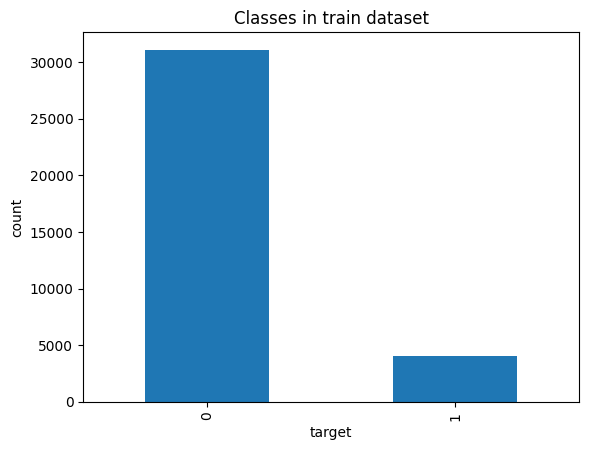

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Аугментація цільового класу для збалансування набору

In [ ]:
def augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=None, add_func=None):
  aug_images_set =[]
  img = load_img(img_path) #завантажує зображення як PIL
  img_arr = img_to_array(img) #конвертує у NumPy
  img_arr = np.expand_dims(img_arr, axis=0)  # додати розмірність - batch
  for i in range(num_aug):
    augmented_img_arr = data_augmentation(img_arr, training=True)
    # augmented_img = keras.utils.array_to_img(augmented_img_arr[0])
    augmented_img = array_to_img(augmented_img_arr[0])   #first in batch
    if add_func is not None:
      augmented_img = add_func(augmented_img)
    aug_images_set.append(augmented_img)
    if save:
      os.makedirs(output_dir, exist_ok=True)
      img_name = os.path.basename(img_path)
      output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg")
      save_img(output_path, augmented_img)
  return aug_images_set

def run_augmentation(data_augmentation, input_dir, output_dir, num_aug, add_func=None):
  for img_name in os.listdir(input_dir):
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

def run_selective_augmentation(data_augmentation, input_dir, output_dir, num_aug, ratio=0.3, my_seed=42, add_func=None):
  """augmentation of subset"""
  np.random.seed(my_seed)
  images = os.listdir(input_dir)
  images_to_augm = np.random.choice(images, int(len(images)*ratio), replace=False)
  for img_name in images_to_augm:
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

In [ ]:
def add_files(source_dir, dest_dir):
  os.makedirs(dest_dir, exist_ok=True)
  for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    if os.path.isfile(source_file):
      destination_file = os.path.join(dest_dir, file_name)
      shutil.copyfile(source_file, destination_file)

In [ ]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomZoom(0.3),
      layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      # layers.MixUp(alpha=0.2),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.1,
          contrast_factor=0.1,
          saturation_factor=(0.46, 0.54),
          hue_factor=0.05)
    ]
)

In [ ]:
# shutil.rmtree("/content/augmented")

In [ ]:
input_dir = pathlib.Path("/content/2020_supplemented/train/melanoma")
output_dir = pathlib.Path("/content/augmented")

Аугментація зображень з тренувального набору (вибірка) для класу "меланома".

In [ ]:
np.random.seed(42)
augm_example = np.random.choice(os.listdir(input_dir), 1)[0]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

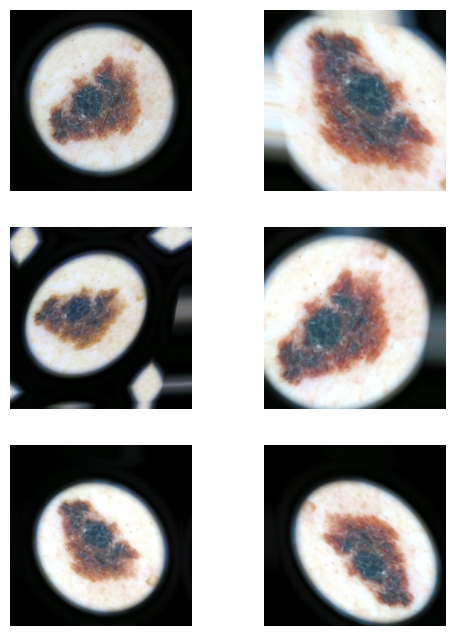

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

In [ ]:
run_augmentation(data_augmentation, input_dir, output_dir, 4)

In [ ]:
show_dirs_len(output_dir)

.: 16300


In [ ]:
# зберегти за потреби аугментовані зображення
!zip -q -r 2020_train_melanoma_augmented_full.zip . -i /augmented/*
from google.colab import files
files.download("2020_train_melanoma_augmented_full.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# зберегти за потреби вибірку без аугментації
!zip -q -r full_ds_1920_no_augm.zip /content/2020_supplemented/
from google.colab import files
files.download("full_ds_1920_no_augm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# додати аугментовані файли у вибірку
add_files(output_dir, input_dir)

In [ ]:
show_dirs_len(input_dir)

.: 20375


In [ ]:
show_dirs_len(data_dir)

.: 3
validation: 2
validation/melanoma: 1018
validation/other: 1118
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 20375
train/other: 31094


In [ ]:
# зберегти вибірку з аугментацією цільового класу
!zip -q -r full_ds_1920_with_augm.zip /content/2020_supplemented/
from google.colab import files
files.download("full_ds_1920_with_augm.zip")

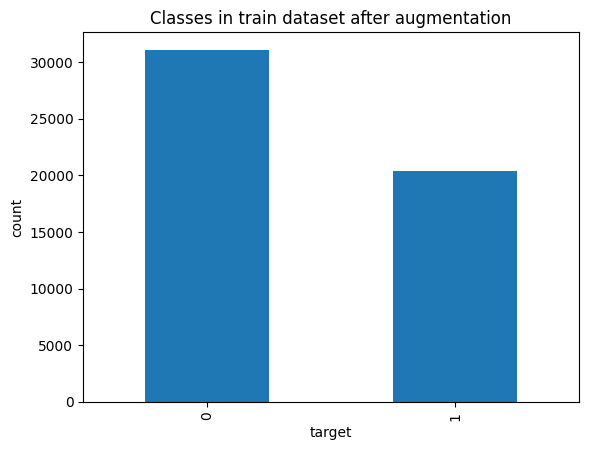

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset after augmentation')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Завантаження даних для навчання

In [ ]:
# весь датасет з аугментацією 1:4
# https://drive.google.com/file/d/1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7/view?usp=sharing
file_id = "1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_1920_with_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7
From (redirected): https://drive.google.com/uc?id=1Jr-SkgzsDrLh_e_kgsa39bQ22w9aNWr7&confirm=t&uuid=6ace5993-2274-4c56-b43c-92971f0ba806
To: /content/full_ds_1920_with_augm.zip
100%|██████████| 1.71G/1.71G [00:33<00:00, 50.5MB/s]


'full_ds_1920_with_augm.zip'

In [ ]:
!unzip -q full_ds_1920_with_augm.zip

In [ ]:
data_dir = pathlib.Path("/content/content/2020_supplemented")
show_dirs_len(data_dir)

.: 3
validation: 2
validation/other: 1118
validation/melanoma: 1018
test: 2
test/other: 10638
test/melanoma: 1587
train: 2
train/other: 31094
train/melanoma: 20375


## Визначення параметрів, функцій для побудови моделі

In [ ]:
def generate_model_version_name():

  from datetime import datetime

  now = datetime.now()
  month_day = now.strftime("%m-%d")  # Формат: ММ-ДД
  hours = now.strftime("%H")  # Формат: ЧЧ, тільки години
  return month_day + "-" + hours

In [ ]:
# при дисбалансі класів
def binary_class_weights(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log([count_1/count_0])


In [ ]:
# при дисбалансі класів при відомій кількості екземплярів кожного класу
def binary_class_weights_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log(count_1/count_0)

In [ ]:
# логування
import csv
from tensorflow.keras.callbacks import Callback

# зібрати під час навчання метрики
class MetricsLogger(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.metrics = None
        # create file on init
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
    # method Callbak class
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # get logs keys
        if self.metrics is None:
          self.metrics = list(logs.keys())
            # add metrics header to csv
          with open(self.filepath, mode='a', newline='') as f:
              writer = csv.writer(f)
              writer.writerow(['epoch'] + self.metrics)
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch] + [logs[m] for m in self.metrics])

In [ ]:
# візуалізація
def plot_scores (df, model_name, metrics_list):
  n = len(metrics_list)
  fig = plt.figure(figsize=(16, int(np.ceil(n/3)*4) ))
  fig.suptitle(f'{model_name}')
  for i, metric in enumerate(metrics_list):
    ax = plt.subplot(int(np.ceil(n/3)), 3, i + 1)
    ax.plot(df.index+1, df[metric], label=metric)
    ax.plot(df.index+1, df["val_" + metric], label="val_" + metric)
    ax.legend(loc='lower right')
    ax.grid(True)
  fig2 = plt.figure(figsize=(8, 6))
  for i, metric in enumerate(metrics_list):
    plt.plot(df.index+1, df[metric], label=metric)
    plt.plot(df.index+1, df["val_" + metric], label="val_" + metric)
  plt.legend(loc='lower right')
  plt.show();

def plot_loss(df, model_name):
  fig = plt.figure(figsize=(8, 6))
  fig.suptitle(f'{model_name + " loss"}')
  plt.plot(df.index+1, df['loss'], label='train loss')
  plt.plot(df.index+1, df["val_loss"], label="validation loss")
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show();

In [ ]:
def plot_confusion_matrix(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "melanoma"])
  disp.plot(cmap=plt.cm.Blues)
  plt.xlabel("Predictions")
  plt.ylabel("Actual")
  plt.title('Confusion matrix')
  plt.show()

In [ ]:
def fbeta_metric(precision, recall, beta=2.0):
  return precision * recall * (1+beta**2)/( (beta**2) * precision + recall)

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]
VERSION = generate_model_version_name()
# MODEL_NAME = f"Basic_model_{VERSION}"
LEARNING_RATE = 1e-5

In [ ]:
VERSION

'04-12-10'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 51469 files belonging to 2 classes.
Found 2136 files belonging to 2 classes.
Found 12225 files belonging to 2 classes.


### Візуалізація датасету

In [ ]:
class_names = train_ds.class_names
print(class_names)

['other', 'melanoma']


In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


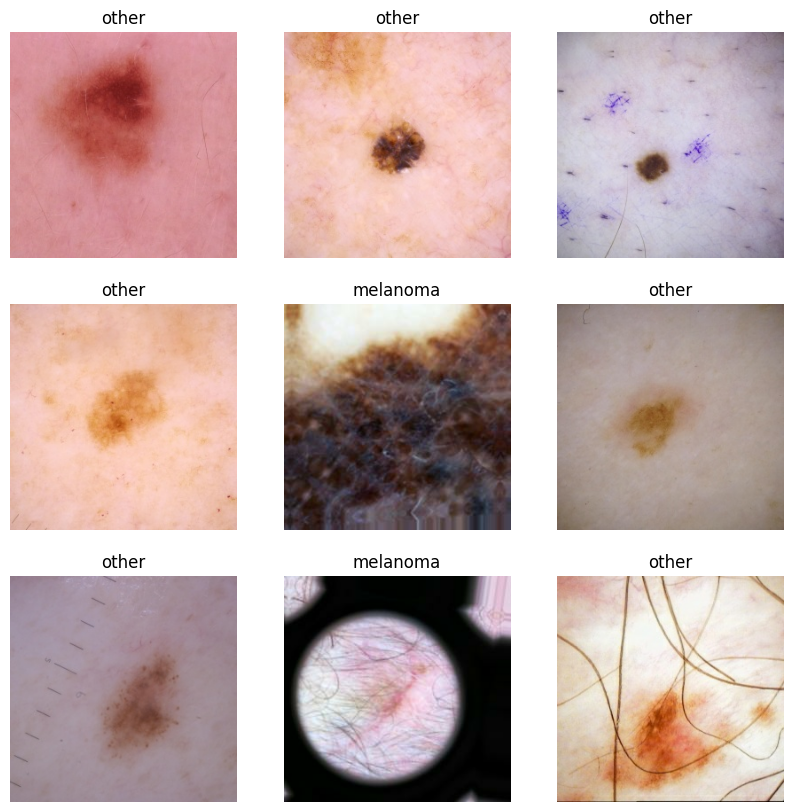

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Створення моделі, передобробка датасету, навчання, оцінка

In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(data_dir / "train/melanoma"))
count_0 = len(os.listdir(data_dir / "train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.83
Weight for class 1: 1.26


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -0.42270621540062264


### Модель

In [ ]:
# створення та компіляція моделі з заданим bias для останнього шару
def make_model(learning_rate=LEARNING_RATE, metrics=METRICS, model=None, output_bias=None):
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  if output_bias is not None:
    model.layers[-1].bias.assign([output_bias])
  return model

In [ ]:
MODEL_NAMES = [f"MobileNetV2_{VERSION}",
              f"Xception_{VERSION}",
              f"ResNet50V2_{VERSION}",
               f"DenseNet121_{VERSION}",
               f"EfficientNetV2B0_{VERSION}"]

In [ ]:
# ! Перезапускати
model_index = 4
MODEL_NAME = MODEL_NAMES[model_index]

In [ ]:
MODEL_NAME

'EfficientNetV2B0_04-12-10'

### small ds Feature extraction models

In [ ]:
# https://drive.google.com/file/d/17p3Y9AFIPC-C3rphCZlDzKBiKKYskFBj/view?usp=sharing
file_id = "17p3Y9AFIPC-C3rphCZlDzKBiKKYskFBj"
url = f"https://drive.google.com/uc?id={file_id}"
output = "feature_extractors.zip"

gdown.download(url, output, quiet=False)
!unzip -q feature_extractors.zip

Downloading...
From (original): https://drive.google.com/uc?id=17p3Y9AFIPC-C3rphCZlDzKBiKKYskFBj
From (redirected): https://drive.google.com/uc?id=17p3Y9AFIPC-C3rphCZlDzKBiKKYskFBj&confirm=t&uuid=83e5d7e3-b607-40f9-86f8-9e01be2c0aac
To: /content/feature_extractors.zip
100%|██████████| 233M/233M [00:04<00:00, 51.3MB/s]


In [ ]:
FEATURE_EXTRACTORS = [
    'small-tl-MobileNetV2_03-27-19.keras',
    'small-tl-Xception_03-29-11.keras',
    'small-tl-ResNet50V2_04-05-14.keras',
    'small-tl-DenseNet121_04-06-14.keras',
    'small-tl-EfficientNetV2B0_04-07-19.keras'
]

In [ ]:
FEATURE_EXTRACTOR = FEATURE_EXTRACTORS[model_index]
FEATURE_EXTRACTOR

'small-tl-EfficientNetV2B0_04-07-19.keras'

In [ ]:
if model_index == 0:
  from keras.applications.mobilenet_v2 import preprocess_input
  IM_SIZE = 256       #224

if model_index == 1:
  from keras.applications.xception import preprocess_input
  IM_SIZE = 256   #229

if model_index == 2:
  from keras.applications.resnet_v2 import preprocess_input
  IM_SIZE = 256   #224

if model_index == 3:
  from keras.applications.densenet import preprocess_input
  IM_SIZE = 256   #224

if model_index == 4:
  from keras.applications.efficientnet_v2 import preprocess_input
  IM_SIZE = 256

# preprocess for fine_tuning:
def preprocess(image, label):
  image = preprocess_input(image)
  return image, label

## EfficientNetV2B0

### Fine tuning

In [ ]:
label = 'ft-'
print(label,  MODEL_NAME)

model_path = f"/content/feature_extractors/{FEATURE_EXTRACTOR}"
tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

ft- EfficientNetV2B0_04-12-13


Оцінка моделі - feature extractor, що навчався на вибірці, на всіх даних перед fine tuning

In [ ]:
# evaluate before FT
tl_model_results = tl_model.evaluate(test_ds, verbose=1)

precision = tl_model_results[2]
recall = tl_model_results[3]
fbeta = fbeta_metric(precision, recall)
tl_model_results.append(fbeta)

383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.9568 - auc: 0.9698 - fn: 137.8802 - fp: 126.2943 - loss: 0.1229 - prc: 0.9117 - precision: 0.8273 - recall: 0.8304 - tn: 5242.8931 - tp: 652.6875


In [ ]:
# metrics before FT
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], tl_model_results):
  print(metric, ': ', value)
print()

loss :  0.12580761313438416
accuracy :  0.9567280411720276
precision :  0.8417312502861023
recall :  0.821045994758606
tp :  1303.0
fp :  245.0
tn :  10393.0
fn :  284.0
auc :  0.9682668447494507
prc :  0.910732626914978
f1_beta :  0.8251013108575054



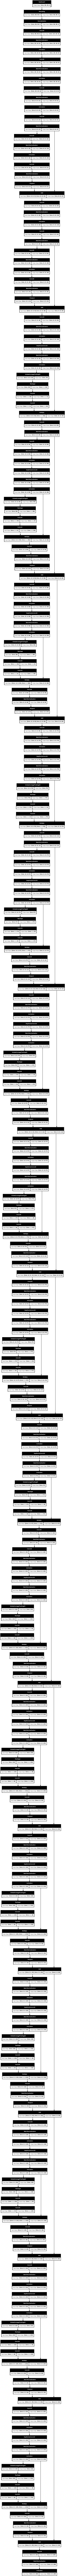

In [ ]:
base_model = tl_model.get_layer('efficientnetv2-b0')
plot_model(base_model, show_shapes=True)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 64, 64,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 64, 64,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 64, 64,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 64, 64,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 64, 64,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
counter=0
for layer in base_model.layers:
  if '6' in layer.name:
    counter +=1
print(counter)

118


Розморожено 121 шар базової моделі

In [ ]:
for layer in base_model.layers[-121:]:
  layer.trainable=True

for layer in base_model.layers[:-121]:
  layer.trainable=False

tl_model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,411,605 (24.46 MB)

 Trainable params: 4,650,797 (17.74 MB)

 Non-trainable params: 1,432,612 (5.46 MB)

 Optimizer params: 328,196 (1.25 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

callbacks_list = [EarlyStopping(monitor='val_recall', patience=10),
                  ReduceLROnPlateau(factor=0.7, patience=4, min_lr=1e-7),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=60

In [ ]:
# EfficientNetV2B0 fine tuning
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 224s 103ms/step - accuracy: 0.9345 - auc: 0.9791 - fn: 724.8354 - fp: 768.0317 - loss: 0.1766 - prc: 0.9748 - precision: 0.9119 - recall: 0.9262 - tn: 14750.3301 - tp: 9532.2754 - val_accuracy: 0.8478 - val_auc: 0.9033 - val_fn: 215.0000 - val_fp: 110.0000 - val_loss: 0.8037 - val_prc: 0.8276 - val_precision: 0.8795 - val_recall: 0.7888 - val_tn: 1008.0000 - val_tp: 803.0000 - learning_rate: 1.0000e-05
Epoch 2/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 126s 75ms/step - accuracy: 0.9667 - auc: 0.9920 - fn: 516.2466 - fp: 330.4876 - loss: 0.0993 - prc: 0.9907 - precision: 0.9680 - recall: 0.9480 - tn: 15178.0049 - tp: 9750.6152 - val_accuracy: 0.8633 - val_auc: 0.9102 - val_fn: 181.0000 - val_fp: 111.0000 - val_loss: 0.8127 - val_prc: 0.8406 - val_precision: 0.8829 - val_recall: 0.8222 - val_tn: 1007.0000 - val_tp: 837.0000 - learning_rate: 1.0000e-05
Epoch 3/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 144s 79ms/step - accuracy: 0.9720 - auc: 0.9935 - fn: 443.3186 

KeyboardInterrupt: 

Перенавчання, зупинка навчання.

In [ ]:
# from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

NameError: name 'history' is not defined

In [ ]:
df_basic = pd.read_csv(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')

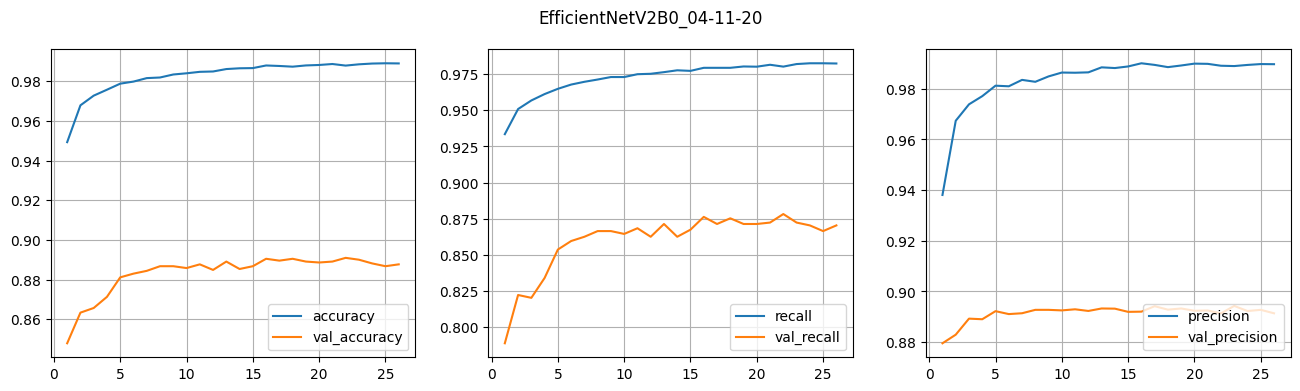

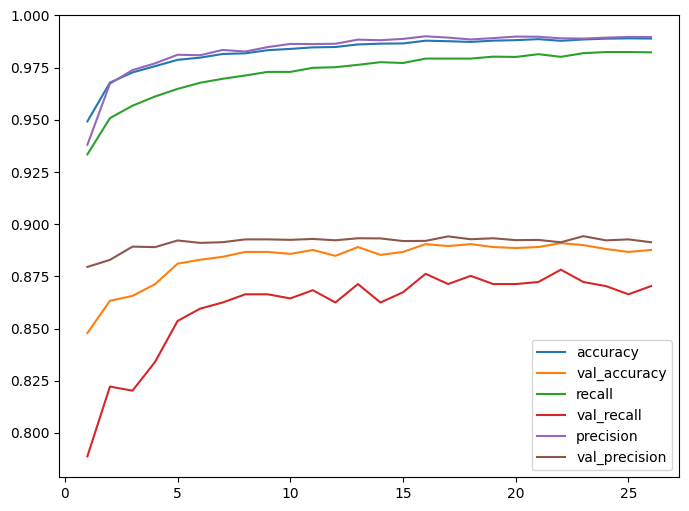

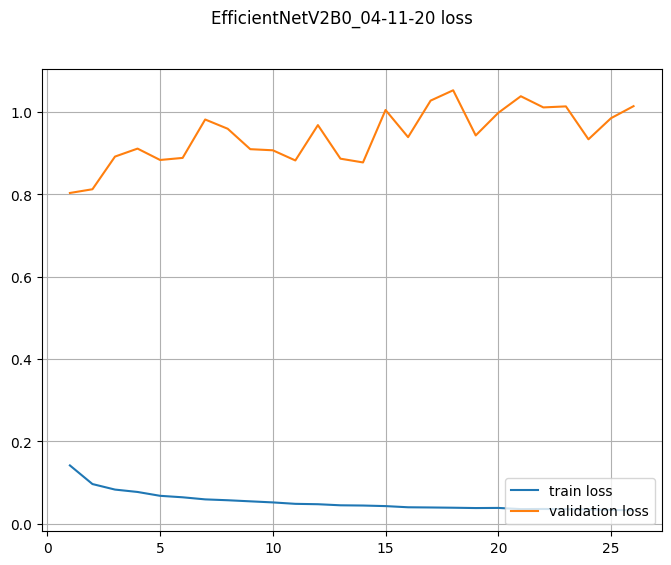

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

In [ ]:
# load best model after fine tuning
model_path = f"/content/ft-{MODEL_NAME}.keras"
best_ft_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_ft_results = best_ft_model.evaluate(test_ds, verbose=1)

precision = best_ft_results[2]
recall = best_ft_results[3]
fbeta = fbeta_metric(precision, recall)
best_ft_results.append(fbeta)

383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9645 - auc: 0.9686 - fn: 170.3073 - fp: 48.5495 - loss: 0.1101 - prc: 0.9113 - precision: 0.9194 - recall: 0.7867 - tn: 5320.6382 - tp: 620.2604


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_ft_results):
  print(metric, ': ', value)
print()

loss :  0.11269628256559372
accuracy :  0.9643353819847107
precision :  0.9304412603378296
recall :  0.7838689088821411
tp :  1244.0
fp :  93.0
tn :  10545.0
fn :  343.0
auc :  0.9689750075340271
prc :  0.9132572412490845
f1_beta :  0.809368874142725



In [ ]:
# Зберегти результат оцінки на тествому наборі
from google.colab import files
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': best_ft_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

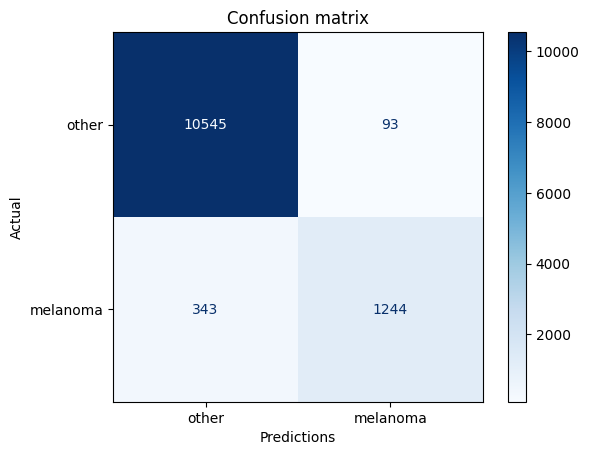

In [ ]:
predictions_array = []
test_labels_array = []
for images, labels in test_ds:
    predictions = best_ft_model.predict(images, verbose=0)
    predictions_array.extend(predictions)
    test_labels_array.extend(labels.numpy())
predictions_array = np.array(predictions_array)
test_labels_array = np.array(test_labels_array)

plot_confusion_matrix(test_labels_array, predictions_array, threshold=0.5)

Після FT підвищився precision, але зменшився recall

### Зміна параметрів навчання, розморожено 130 шарів, відстежування recall для кращої моделі

In [ ]:
for layer in base_model.layers[-130:]:
  layer.trainable=True

for layer in base_model.layers[:-130]:
  layer.trainable=False

tl_model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,411,605 (24.46 MB)

 Trainable params: 4,764,617 (18.18 MB)

 Non-trainable params: 1,318,792 (5.03 MB)

 Optimizer params: 328,196 (1.25 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

callbacks_list = [EarlyStopping(monitor='val_recall', patience=10),
                  ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-7),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_recall', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=60

In [ ]:
# EfficientNetV2B0 fine tuning
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 252s 112ms/step - accuracy: 0.9341 - auc: 0.9788 - fn: 705.2416 - fp: 768.9093 - loss: 0.1758 - prc: 0.9741 - precision: 0.9113 - recall: 0.9268 - tn: 14739.5449 - tp: 9562.0127 - val_accuracy: 0.8511 - val_auc: 0.9045 - val_fn: 202.0000 - val_fp: 116.0000 - val_loss: 0.7793 - val_prc: 0.8283 - val_precision: 0.8755 - val_recall: 0.8016 - val_tn: 1002.0000 - val_tp: 816.0000 - learning_rate: 1.0000e-05
Epoch 2/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 127s 76ms/step - accuracy: 0.9656 - auc: 0.9920 - fn: 523.6429 - fp: 347.2174 - loss: 0.1011 - prc: 0.9906 - precision: 0.9655 - recall: 0.9475 - tn: 15167.1973 - tp: 9737.6396 - val_accuracy: 0.8591 - val_auc: 0.9089 - val_fn: 195.0000 - val_fp: 106.0000 - val_loss: 0.8347 - val_prc: 0.8370 - val_precision: 0.8859 - val_recall: 0.8084 - val_tn: 1012.0000 - val_tp: 823.0000 - learning_rate: 1.0000e-05
Epoch 3/60
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 130s 80ms/step - accuracy: 0.9743 - auc: 0.9939 - fn: 412.2652 

Перенавчання, модель, яка на валідації мала найвищу повноту, на тестуванні показала гіршу повноту, ніж переднавчана модель, як feature extractor.

In [ ]:
last_model = tl_model
last_model.save('ft-EfficientNetV2B0_04-12-10_last.keras')

In [ ]:
from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

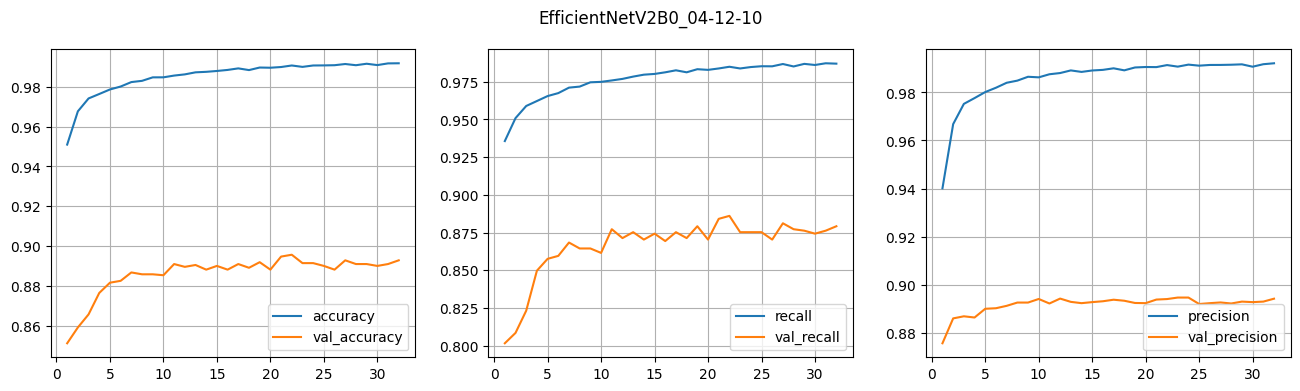

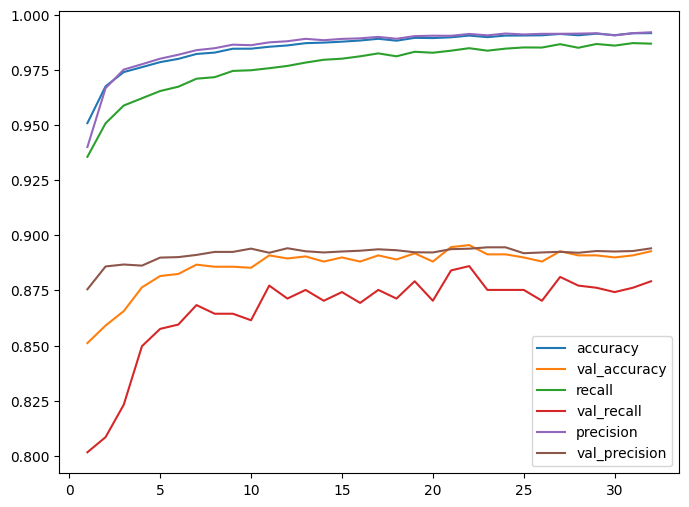

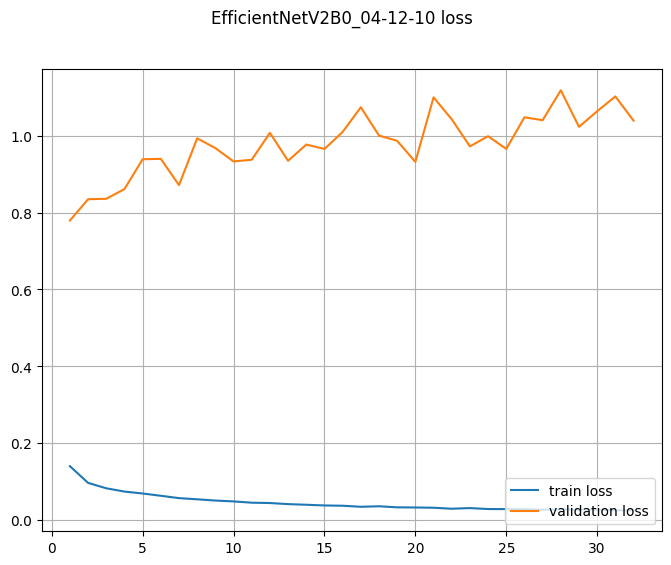

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

Оцінка моделі, визначеної як краща

In [ ]:
# load best model after fine tuning
model_path = f"/content/ft-{MODEL_NAME}.keras"
best_ft_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_ft_results = best_ft_model.evaluate(test_ds, verbose=1)

precision = best_ft_results[2]
recall = best_ft_results[3]
fbeta = fbeta_metric(precision, recall)
best_ft_results.append(fbeta)

383/383 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9635 - auc: 0.9684 - fn: 163.9844 - fp: 58.4792 - loss: 0.1139 - prc: 0.9100 - precision: 0.9048 - recall: 0.7921 - tn: 5310.0493 - tp: 627.2422


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_ft_results):
  print(metric, ': ', value)
print()

loss :  0.1146102324128151
accuracy :  0.9635992050170898
precision :  0.9161807298660278
recall :  0.7920604944229126
tp :  1257.0
fp :  115.0
tn :  10523.0
fn :  330.0
auc :  0.9694216847419739
prc :  0.9134361743927002
f1_beta :  0.8141191690146894



In [ ]:
# Зберегти результат оцінки на тествому наборі
from google.colab import files
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': best_ft_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

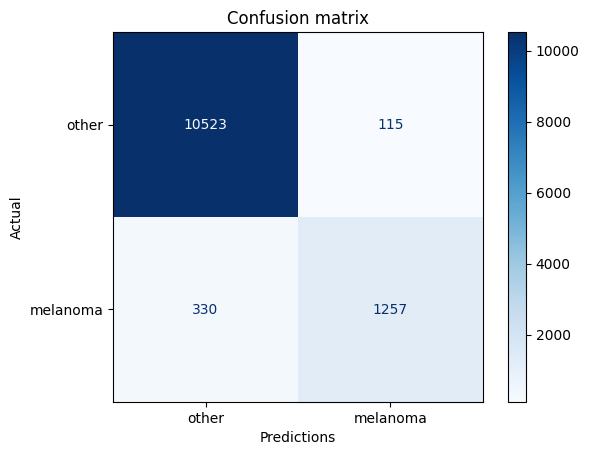

In [ ]:
predictions_array = []
test_labels_array = []
for images, labels in test_ds:
    predictions = best_ft_model.predict(images, verbose=0)
    predictions_array.extend(predictions)
    test_labels_array.extend(labels.numpy())

predictions_array = np.array(predictions_array)
test_labels_array = np.array(test_labels_array)

plot_confusion_matrix(test_labels_array, predictions_array, threshold=0.5)

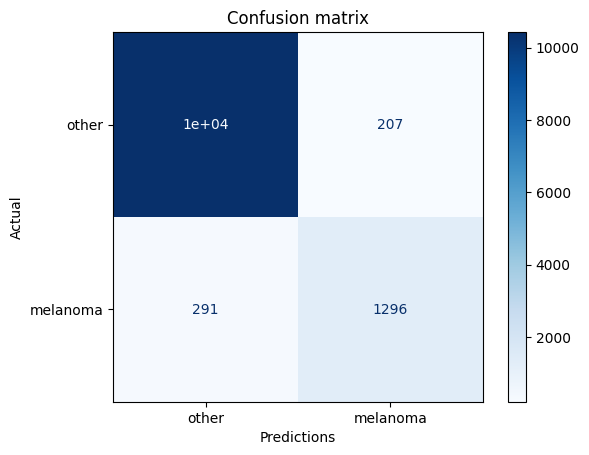

In [ ]:
plot_confusion_matrix(test_labels_array, predictions_array, threshold=0.4)

In [ ]:
print(test_labels_array.shape)
print(predictions_array.shape)
print(predictions_array.ravel().shape)

(12225,)
(12225, 1)
(12225,)


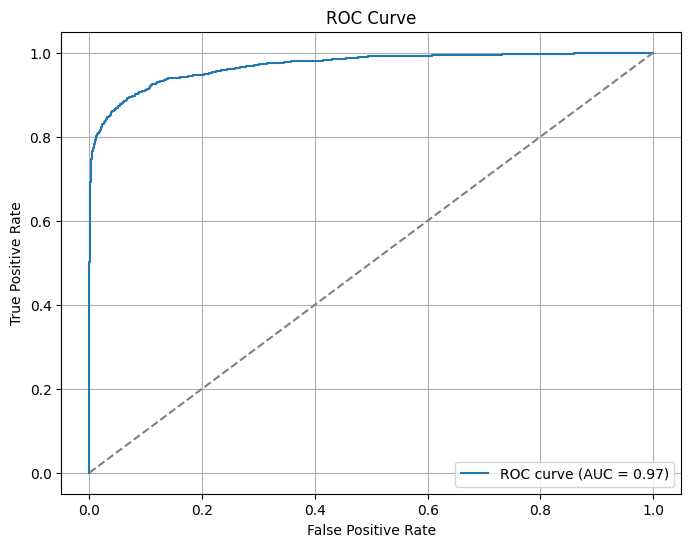

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

predictions_array_rev =predictions_array.ravel()  # приводимо до 1D

fp_rate, tp_rate, _ = roc_curve(test_labels_array, predictions_array_rev)
roc_auc = auc(fp_rate, tp_rate)

plt.figure(figsize=(8, 6))
plt.plot(fp_rate, tp_rate, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

Оцінка останньої моделі

In [ ]:
last_ft_results = last_model.evaluate(test_ds, verbose=1)

precision = last_ft_results[2]
recall = last_ft_results[3]
fbeta = fbeta_metric(precision, recall)
last_ft_results.append(fbeta)

383/383 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.9696 - auc: 0.9693 - fn: 117.9714 - fp: 65.5417 - loss: 0.1060 - prc: 0.9307 - precision: 0.9057 - recall: 0.8475 - tn: 5303.6719 - tp: 672.5703


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], last_ft_results):
  print(metric, ': ', value)
print()

loss :  0.10876479744911194
accuracy :  0.9702249765396118
precision :  0.9151391983032227
recall :  0.8494014143943787
tp :  1348.0
fp :  125.0
tn :  10513.0
fn :  239.0
auc :  0.969168484210968
prc :  0.9309068918228149
f1_beta :  0.8617824086433139



Кращою за повнотою є модель, що була останньою при зупинці навчання, але не кращою на валідації. Ненадійна валідація

In [ ]:
# Зберегти результат оцінки на тествому наборі
from google.colab import files
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': last_ft_results})
df_eval.to_csv(f'evaluate_results_last{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_last{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

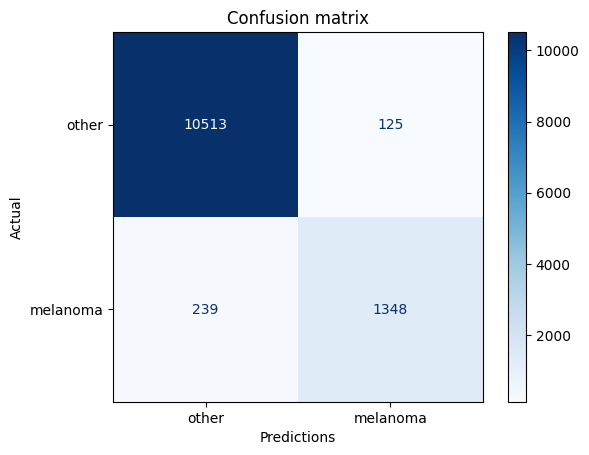

In [ ]:
predictions_array = []
test_labels_array = []
for images, labels in test_ds:
    predictions = last_model.predict(images, verbose=0)
    predictions_array.extend(predictions)
    test_labels_array.extend(labels.numpy())

predictions_array = np.array(predictions_array)
test_labels_array = np.array(test_labels_array)

plot_confusion_matrix(test_labels_array, predictions_array, threshold=0.5)

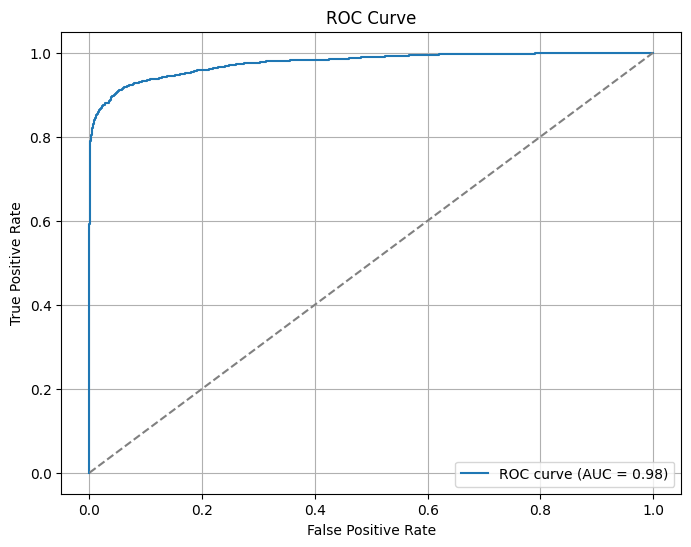

In [ ]:
predictions_array_rev =predictions_array.ravel()  # приводимо до 1D

fp_rate, tp_rate, _ = roc_curve(test_labels_array, predictions_array_rev)
roc_auc = auc(fp_rate, tp_rate)

plt.figure(figsize=(8, 6))
plt.plot(fp_rate, tp_rate, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

Перевірка на валідаційному наборі

In [ ]:
# evaluate on validation dataset last model, that has better metrics
model_path = f"/content/ft-EfficientNetV2B0_04-12-10_last.keras"
eval_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})
eval_results = eval_model.evaluate(val_ds, verbose=1)

precision = eval_results[2]
recall = eval_results[3]
fbeta = fbeta_metric(precision, recall)
eval_results.append(fbeta)

for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], eval_results):
  print(metric, ': ', value)
print()

67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.8941 - auc: 0.9315 - fn: 62.7500 - fp: 52.6471 - loss: 1.0667 - prc: 0.8793 - precision: 0.8940 - recall: 0.8787 - tn: 526.9265 - tp: 460.9706
loss :  1.0392274856567383
accuracy :  0.8927902579307556
precision :  0.8941059112548828
recall :  0.8791748285293579
tp :  895.0
fp :  106.0
tn :  1012.0
fn :  123.0
auc :  0.9290424585342407
prc :  0.8795769214630127
f1_beta :  0.8821210168299647



## Predictions

In [ ]:
def get_predictions_df(model, img_size=(256, 256), batch_size=32, images_folder=None, dataset=None, threshold = 0.5):
  if images_folder is not None:
    dataset = tf.keras.utils.image_dataset_from_directory(
    images_folder,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
    )
  # get filenames, dataset.file_paths
  file_paths = dataset.file_paths

  predictions = model.predict(dataset, verbose=0)
  predicted_labels = (predictions >= threshold).astype(int)
  true_labels = [0 if 'other' in fp else 1 for fp in file_paths]

  predictions_df = pd.DataFrame({
      'file_path': file_paths,
      'true_label': true_labels,
      'predicted_label': np.concatenate(np.array(predicted_labels), axis=0),
      'predicted_prob': np.concatenate(np.array(predictions), axis=0)
  })
  return predictions_df

In [ ]:
def get_predictions_df2(model, img_size=(256, 256), batch_size=32, images_folder=None, dataset=None, threshold = 0.5):
  """same as get_predictions_df, but using iteration, accepts tf.Dataset or folder path"""

  if images_folder is not None:
    dataset = tf.keras.utils.image_dataset_from_directory(
    images_folder,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
    )

  predictions_array = []
  true_labels_array = []
  for images in dataset:
      predictions = model.predict(images, verbose=0)
      predictions_array.extend(predictions)
  file_paths = dataset.file_paths
  true_labels = [0 if 'other' in fp else 1 for fp in file_paths]
  predictions_array = np.concatenate(np.array(predictions_array), axis=0)
  # true_labels_array = np.array(true_labels)
  predicted_labels = (predictions_array >= threshold).astype(int)

  predictions_df = pd.DataFrame({
      'file_path': file_paths,
      'true_label': true_labels,
      'predicted_label': predicted_labels,
      'predicted_prob': predictions_array
  })
  return predictions_df

In [ ]:
def show_predicted(images_pathes):
  num = len(images_pathes)
  plt.figure(figsize=(15, np.ceil(num/5)*3))

  for i, im in enumerate(images_pathes):
    ax = plt.subplot(int(np.ceil(num/5)), 5, i + 1)
    image = Image.open(im)
    plt.imshow(img_to_array(image).astype("uint8"))
    plt.title(f"True: {predictions_df.true_label[predictions_df['file_path']==im].values[0]}, Predicted: {predictions_df.predicted_prob[predictions_df['file_path']==im].values[0]: .2f}")
    plt.axis("off")

## Перевірка передбачень на зображеннях

Перевірка моделі ft-EfficientNetV2B0_04-12-10_last.keras на зображеннях з темним фоном з датасету 2019 року класс other.

In [ ]:
# https://drive.google.com/file/d/11VpzypsPua9QzonH0llk4NuZJnt_vsms/view?usp=sharing
file_id = "11VpzypsPua9QzonH0llk4NuZJnt_vsms"
url = f"https://drive.google.com/uc?id={file_id}"
output = "vignette.zip"

gdown.download(url, output, quiet=False)
!unzip -q vignette.zip

Downloading...
From (original): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms
From (redirected): https://drive.google.com/uc?id=11VpzypsPua9QzonH0llk4NuZJnt_vsms&confirm=t&uuid=4c527ace-6101-4b00-92f7-878f2d6863e6
To: /content/vignette.zip
100%|██████████| 45.3M/45.3M [00:01<00:00, 37.6MB/s]


In [ ]:
!mkdir -p /content/vignette/other
!mkdir -p /content/vignette/melanoma
!mv /content/vignette/*.jpg /content/vignette/other/

In [ ]:
from keras.applications.efficientnet_v2 import preprocess_input
from sklearn.metrics import classification_report, precision_recall_fscore_support

model_path = '/content/ft-EfficientNetV2B0_04-12-10_last.keras'
model_to_test = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})
img_size = (256, 256)
batch_size = 32

In [ ]:
images_folder = pathlib.Path('/content/vignette')
predictions_df = get_predictions_df(model_to_test, img_size=(256, 256), batch_size=32, images_folder=images_folder)
print(classification_report(predictions_df['true_label'], predictions_df['predicted_label']))
print(precision_recall_fscore_support(predictions_df['true_label'], predictions_df['predicted_label'], beta=2.0, average='weighted'))

predictions_df.to_csv(f'Predictions_ft-EfficientNetV2B0_04-12-10_last_vignetted.csv', index=False)
from google.colab import files
files.download(f'Predictions_ft-EfficientNetV2B0_04-12-10_last_vignetted.csv')

Found 2963 files.
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2963
           1       0.00      0.00      0.00         0

    accuracy                           0.00      2963
   macro avg       0.50      0.00      0.00      2963
weighted avg       1.00      0.00      0.00      2963

(1.0, 0.0013499831252109348, 0.0016869095816464238, None)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
predictions_df.head()

file_path  true_label  predicted_label  \
0  /content/vignette/other/ISIC_0000071.jpg           0                1   
1  /content/vignette/other/ISIC_0000249.jpg           0                1   
2  /content/vignette/other/ISIC_0000275.jpg           0                1   
3  /content/vignette/other/ISIC_0027361.jpg           0                0   
4  /content/vignette/other/ISIC_0030835.jpg           0                0   

   predicted_prob  
0        0.999998  
1        0.998842  
2        0.963638  
3        0.392960  
4        0.055860

In [ ]:
mask_fp = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 1)
mask_fn = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 0)
mask_tn = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 0)
mask_tp = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 1)
fp_images_pathes = predictions_df.file_path[mask_fp]
fn_images_pathes = predictions_df.file_path[mask_fn]
tp_images_pathes = predictions_df.file_path[mask_tp]
tn_images_pathes = predictions_df.file_path[mask_tn]
print(f'FP: {len(fp_images_pathes)}, FN: {len(fn_images_pathes)}')
print(f'TP: {len(tp_images_pathes)}, TN: {len(tn_images_pathes)}')

FP: 2959, FN: 0
TP: 0, TN: 4


False Positive:


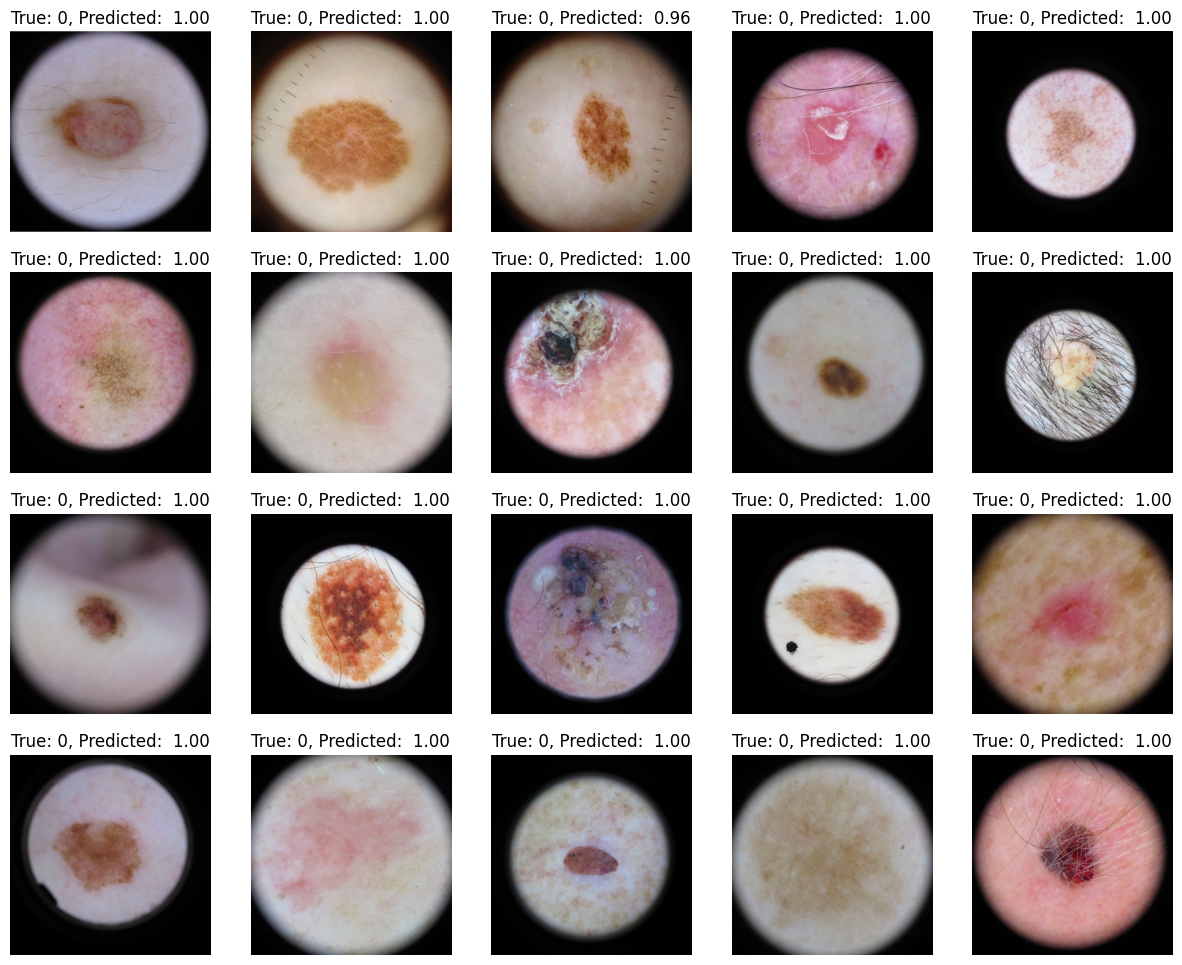

In [ ]:
# Візуалізація FP
print("False Positive:")
plt.figure(figsize=(15, 12))

for i, im in enumerate(fp_images_pathes[:20]):  # перші 20 екземплярів
  ax = plt.subplot(4, 5, i + 1)
  image = Image.open(im)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.title(f"True: {predictions_df.true_label[predictions_df['file_path']==im].values[0]}, Predicted: {predictions_df.predicted_prob[predictions_df['file_path']==im].values[0]: .2f}")
  plt.axis("off")

Всі зображення з темним фоном класифікуються як позитивні.

Перевірка тестового набору моделі ft-EfficientNetV2B0_04-12-10_last.keras

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=img_size,
  batch_size=batch_size,
  shuffle=False)

Found 12225 files.


In [ ]:
predictions_df = get_predictions_df(model_to_test, img_size=(256, 256), batch_size=32, dataset=test_dataset)
print(classification_report(predictions_df['true_label'], predictions_df['predicted_label']))
print(precision_recall_fscore_support(predictions_df['true_label'], predictions_df['predicted_label'], beta=2.0, average='weighted'))

predictions_df.to_csv(f'Predictions_ft-EfficientNetV2B0_04-12-10_last_test_ds.csv', index=False)
from google.colab import files
files.download(f'Predictions_ft-EfficientNetV2B0_04-12-10_last_test_ds.csv')

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10638
           1       0.92      0.85      0.88      1587

    accuracy                           0.97     12225
   macro avg       0.95      0.92      0.93     12225
weighted avg       0.97      0.97      0.97     12225

(0.9696408920866273, 0.9702249488752557, 0.969993025327979, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mask_fp = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 1)
mask_fn = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 0)
mask_tn = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 0)
mask_tp = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 1)
fp_images_pathes = predictions_df.file_path[mask_fp]
fn_images_pathes = predictions_df.file_path[mask_fn]
tp_images_pathes = predictions_df.file_path[mask_tp]
tn_images_pathes = predictions_df.file_path[mask_tn]
print(f'FP: {len(fp_images_pathes)}, FN: {len(fn_images_pathes)}')
print(f'TP: {len(tp_images_pathes)}, TN: {len(tn_images_pathes)}')

FP: 125, FN: 239
TP: 1348, TN: 10513


False Negative:


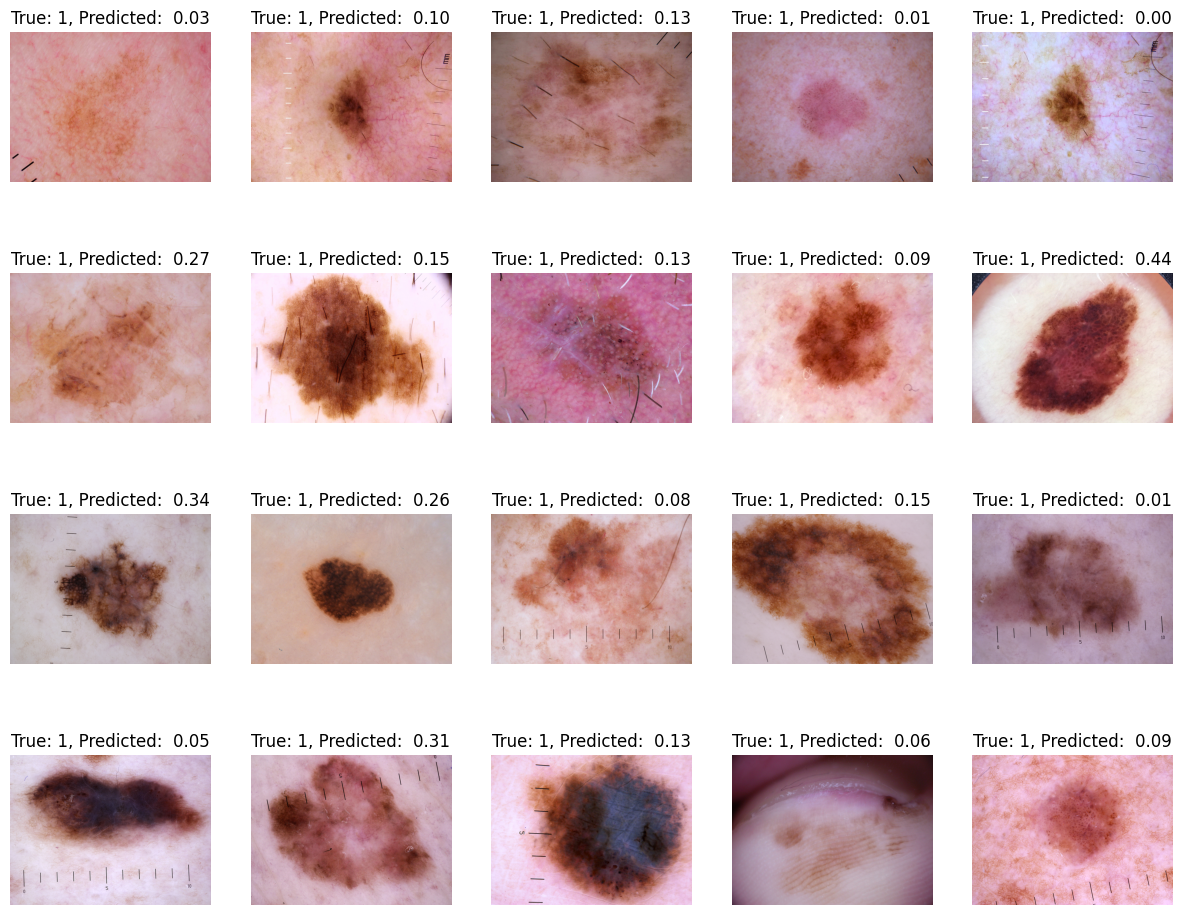

In [ ]:
# Візуалізація FN
print("False Negative:")
show_predicted(fn_images_pathes[:20])

False Positive:


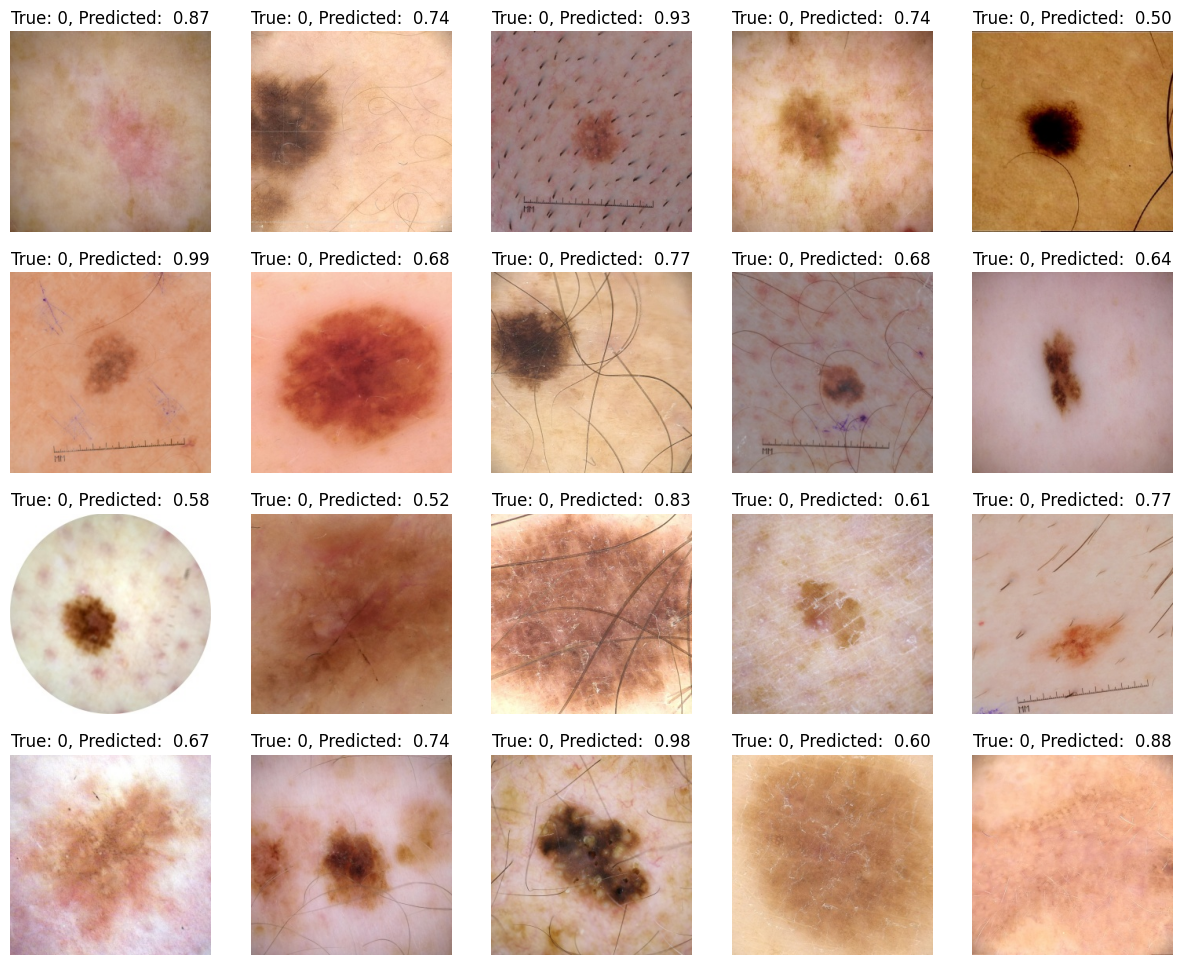

In [ ]:
# Візуалізація FP
print("False Positive:")
show_predicted(fp_images_pathes[:20])

### Зменшення шарів, BN trainable

In [ ]:
label = 'ft-'
print(label,  MODEL_NAME)

model_path = f"/content/ft-EfficientNetV2B0_04-12-10_last.keras"
tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

In [ ]:
for layer in base_model.layers[-30:]:
  layer.trainable=True

for layer in base_model.layers[:-30]:
  layer.trainable=False

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

tl_model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,411,605 (24.46 MB)

 Trainable params: 1,378,337 (5.26 MB)

 Non-trainable params: 4,705,072 (17.95 MB)

 Optimizer params: 328,196 (1.25 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

callbacks_list = [EarlyStopping(monitor='val_auc', patience=10),
                  ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-7),
                  ModelCheckpoint(f'{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=50


In [ ]:
# EfficientNetV2B0 fine tuning
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/50
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 286s 132ms/step - accuracy: 0.8863 - auc: 0.9529 - fn: 1048.6243 - fp: 1559.6727 - loss: 0.2842 - prc: 0.9444 - precision: 0.8346 - recall: 0.8947 - tn: 13952.3975 - tp: 9214.6016 - val_accuracy: 0.7790 - val_auc: 0.8847 - val_fn: 356.0000 - val_fp: 116.0000 - val_loss: 0.6862 - val_prc: 0.8060 - val_precision: 0.8509 - val_recall: 0.6503 - val_tn: 1002.0000 - val_tp: 662.0000 - learning_rate: 1.0000e-05
Epoch 2/50
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 176s 109ms/step - accuracy: 0.9443 - auc: 0.9827 - fn: 784.9398 - fp: 623.8006 - loss: 0.1567 - prc: 0.9792 - precision: 0.9372 - recall: 0.9223 - tn: 14893.5752 - tp: 9473.2402 - val_accuracy: 0.7978 - val_auc: 0.8941 - val_fn: 321.0000 - val_fp: 111.0000 - val_loss: 0.7373 - val_prc: 0.8111 - val_precision: 0.8626 - val_recall: 0.6847 - val_tn: 1007.0000 - val_tp: 697.0000 - learning_rate: 1.0000e-05
Epoch 3/50
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 185s 115ms/step - accuracy: 0.9545 - auc: 0.9872 - fn: 694.2

KeyboardInterrupt: 